In [2]:
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB

In [3]:
loan_data = pd.read_csv('./DataSets/loan_data.csv.gz')

In [4]:
# convert to categorical
loan_data.outcome = loan_data.outcome.astype('category')
loan_data.outcome.cat.reorder_categories(['paid off', 'default'])
loan_data.purpose_ = loan_data.purpose_.astype('category')
loan_data.home_ = loan_data.home_.astype('category')
loan_data.emp_len_ = loan_data.emp_len_.astype('category')

predictors = ['purpose_', 'home_', 'emp_len_']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='')
y = loan_data[outcome]

In [5]:
naive_model = MultinomialNB(alpha=0.01, fit_prior=True)
naive_model.fit(X, y)

MultinomialNB(alpha=0.01)

In [5]:
new_loan = X.loc[146:146, :]
print('predicted class: ', naive_model.predict(new_loan)[0])

probabilities = pd.DataFrame(naive_model.predict_proba(new_loan),
                             columns=naive_model.classes_)
print('predicted probabilities',)
probabilities

predicted class:  default
predicted probabilities


,default,paid off
0,0.653696,0.346304


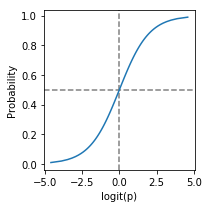

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

p = np.arange(0.01, 1, 0.01)
df = pd.DataFrame({
    'p': p,
    'logit': np.log(p / (1 - p)),
    'odds': p / (1 - p),
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.axvline(0, color='grey', linestyle='--')
ax.axhline(0.5, color='grey', linestyle='--')
ax.plot(df['logit'], df['p'])
ax.set_ylabel('Probability')
ax.set_xlabel('logit(p)')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.linear_model import LogisticRegression

predictors = ['purpose_', 'home_', 'emp_len_']

outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

LogisticRegression(C=1e+42, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
new_loan = X.loc[146:146, :]

print('predicted class: ', logit_reg.predict(new_loan)[0])

probabilities = pd.DataFrame(logit_reg.predict_proba(new_loan),
                             columns=logit_reg.classes_)
print()
print('predicted probabilities: ')
probabilities

predicted class:  default

predicted probabilities: 


,default,paid off
0,0.658086,0.341914


In [9]:
print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -0.10330239562885249
classes ['default' 'paid off']


,coeff
debt_consolidation,-0.260492
home_improvement,-0.106634
major_purchase,0.157170
medical,-0.204026
other,-0.329056
small_business,-1.012170
OWN,-0.138570
RENT,-0.240933
> 1 Year,0.460696


In [10]:
print(loan_data['purpose_'].cat.categories)
print(loan_data['home_'].cat.categories)
print(loan_data['emp_len_'].cat.categories)

Index(['credit_card', 'debt_consolidation', 'home_improvement',
       'major_purchase', 'medical', 'other', 'small_business'],
      dtype='object')
Index(['MORTGAGE', 'OWN', 'RENT'], dtype='object')
Index([' < 1 Year', ' > 1 Year'], dtype='object')


In [20]:
predictors = ['payment_inc_ratio', 'purpose_', 'home_', 'emp_len_', 
              'borrower_score']
outcome = 'outcome'
X = pd.get_dummies(loan_data[predictors], prefix='', prefix_sep='', 
                   drop_first=True)
y = loan_data[outcome] # .cat.categories

logit_reg = LogisticRegression(penalty='l2', C=1e42, solver='liblinear')
logit_reg.fit(X, y)

print('intercept ', logit_reg.intercept_[0])
print('classes', logit_reg.classes_)
pd.DataFrame({'coeff': logit_reg.coef_[0]}, 
             index=X.columns)

intercept  -1.6378907654878294
classes ['default' 'paid off']


,coeff
payment_inc_ratio,-0.079739
borrower_score,4.612183
debt_consolidation,-0.249414
home_improvement,-0.407734
major_purchase,-0.229710
medical,-0.510744
other,-0.620800
small_business,-1.214936
OWN,-0.048211
RENT,-0.157288


In [11]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score

In [21]:
# Confusion matrix
pred = logit_reg.predict(X)
pred_y = logit_reg.predict(X) == 'default'
true_y = y == 'default'
true_pos = true_y & pred_y
true_neg = ~true_y & ~pred_y
false_pos = ~true_y & pred_y
false_neg = true_y & ~pred_y

conf_mat = pd.DataFrame([[np.sum(true_pos), np.sum(false_neg)], [np.sum(false_pos), np.sum(true_neg)]],
                       index=['Y = default', 'Y = paid off'],
                       columns=['Yhat = default', 'Yhat = paid off'])
print(conf_mat)

              Yhat = default  Yhat = paid off
Y = default            14337             8334
Y = paid off            8149            14522


In [22]:
print(confusion_matrix(y, logit_reg.predict(X)))

[[14337  8334]
 [ 8149 14522]]


In [23]:
# classificationSummary(y, logit_reg.predict(X),
#                       class_names=logit_reg.classes_)

In [24]:
conf_mat = confusion_matrix(y, logit_reg.predict(X))
print('Precision', conf_mat[0, 0] / sum(conf_mat[:, 0]))
print('Recall', conf_mat[0, 0] / sum(conf_mat[0, :]))
print('Specificity', conf_mat[1, 1] / sum(conf_mat[1, :]))

Precision 0.6375967268522637
Recall 0.6323938070662961
Specificity 0.640554011733051


In [25]:
precision_recall_fscore_support(y, logit_reg.predict(X),
                                labels=['default', 'paid off'])

(array([0.63759673, 0.63536927]),
 array([0.63239381, 0.64055401]),
 array([0.63498461, 0.63795111]),
 array([22671, 22671], dtype=int64))

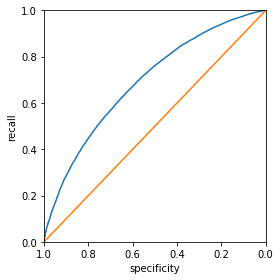

In [26]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:, 0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')


plt.tight_layout()
plt.show()

In [27]:
print(np.sum(roc_df.recall[:-1] * np.diff(1 - roc_df.specificity)))
print(roc_auc_score([1 if yi == 'default' else 0 for yi in y], logit_reg.predict_proba(X)[:, 0]))

0.6917107116268887
0.6917107894518006


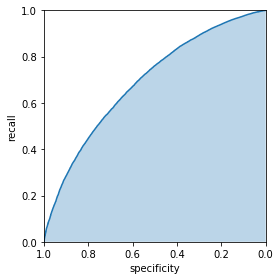

In [28]:
fpr, tpr, thresholds = roc_curve(y, logit_reg.predict_proba(X)[:,0], 
                                 pos_label='default')
roc_df = pd.DataFrame({'recall': tpr, 'specificity': 1 - fpr})

ax = roc_df.plot(x='specificity', y='recall', figsize=(4, 4), legend=False)
ax.set_ylim(0, 1)
ax.set_xlim(1, 0)
# ax.plot((1, 0), (0, 1))
ax.set_xlabel('specificity')
ax.set_ylabel('recall')
ax.fill_between(roc_df.specificity, 0, roc_df.recall, alpha=0.3)


plt.tight_layout()
plt.show()